# Importing all the necessary libraries

In [1]:
# Importing libraries

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import streamlit as st
import pyspark.pandas as ps
import datetime
from pyspark.sql import SparkSession

from sklearn import metrics
from sklearn import preprocessing
from sklearn import tree

from sklearn.impute import SimpleImputer

import statsmodels.formula.api as SM
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import confusion_matrix,classification_report,accuracy_score,roc_auc_score,roc_curve


from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier




2022-05-13 10:18:04.077 WARNING root: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.


# Reading data

In [2]:
# Read data

spark_session = SparkSession.builder.getOrCreate()

data = spark_session.read.csv('E Commerce Dataset.csv',sep = ',', inferSchema = True, header = True)

data = ps.DataFrame(data)
data

,CustomerID,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
0,50004,1,NaN,Mobile Phone,1,16.0,Debit Card,Female,2.0,4,Mobile Phone,1,Single,8,0,23.0,0.0,1.0,3.0,134
1,50002,1,NaN,Phone,1,8.0,UPI,Male,3.0,4,Mobile,3,Single,7,1,15.0,0.0,1.0,0.0,121
2,50003,1,NaN,Phone,1,30.0,Debit Card,Male,2.0,4,Mobile,3,Single,6,1,14.0,0.0,1.0,3.0,120
3,50005,1,0.0,Computer,1,30.0,COD,Male,3.0,4,Fashion,1,Single,3,0,11.0,1.0,1.0,3.0,130
4,50006,1,7.0,Mobile Phone,2,6.0,Credit Card,Male,3.0,4,Fashion,1,Single,2,1,22.0,4.0,6.0,7.0,139
5,50016,1,0.0,Mobile Phone,3,10.0,Cash on Delivery,Male,2.0,3,Fashion,1,Married,5,1,22.0,1.0,1.0,2.0,121
6,50026,1,0.0,Mobile Phone,3,15.0,E wallet,Female,3.0,3,Laptop & Accessory,1,Single,8,0,22.0,1.0,1.0,4.0,142
7,50047,1,0.0,Mobile Phone,3,29.0,Debit Card,Female,2.0,4,Fashion,1,Single,1,0,21.0,1.0,1.0,0.0,123
8,50009,1,13.0,Phone,3,9.0,E wallet,Male,NaN,4,Mobile,3,Divorced,2,1,14.0,0.0,1.0,2.0,127
9,50010,1,NaN,Phone,1,31.0,Debit Card,Male,2.0,5,Mobile,3,Single,2,0,12.0,1.0,1.0,1.0,123


# Dropping the Customer ID column

In [3]:
data.info()
data['Churn'].value_counts()
data['Churn'].value_counts(normalize=True)
# Dropping the CustomerID column
data=data.drop('CustomerID',axis=1)

<class 'pyspark.pandas.frame.DataFrame'>
Int64Index: 5629 entries, 0 to 5628
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   CustomerID                   5629 non-null   int32 
 1   Churn                        5629 non-null   int32 
 2   Tenure                       5365 non-null   int32 
 3   PreferredLoginDevice         5629 non-null   object
 4   CityTier                     5629 non-null   int32 
 5   WarehouseToHome              5378 non-null   int32 
 6   PreferredPaymentMode         5629 non-null   object
 7   Gender                       5629 non-null   object
 8   HourSpendOnApp               5374 non-null   int32 
 9   NumberOfDeviceRegistered     5629 non-null   int32 
 10  PreferedOrderCat             5629 non-null   object
 11  SatisfactionScore            5629 non-null   int32 
 12  MaritalStatus                5629 non-null   object
 13  NumberOfAddress              5

In [4]:
data.head()

,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
0,1,NaN,Mobile Phone,1,16,Debit Card,Female,2,4,Mobile Phone,1,Single,8,0,23,0,1,3,134
1,1,NaN,Phone,1,8,UPI,Male,3,4,Mobile,3,Single,7,1,15,0,1,0,121
2,1,NaN,Phone,1,30,Debit Card,Male,2,4,Mobile,3,Single,6,1,14,0,1,3,120
3,1,0.0,Computer,1,30,COD,Male,3,4,Fashion,1,Single,3,0,11,1,1,3,130
4,1,7.0,Mobile Phone,2,6,Credit Card,Male,3,4,Fashion,1,Single,2,1,22,4,6,7,139


In [5]:
data.columns
data['PreferredPaymentMode']=data['PreferredPaymentMode'].replace('CC','Credit Card').replace('COD','Cash on Delivery')
data['PreferedOrderCat']=data['PreferedOrderCat'].replace('Mobile','Mobile Phone')
data['PreferredLoginDevice']=data['PreferredLoginDevice'].replace('Phone','Mobile Phone')
data['PreferredLoginDevice']=data['PreferredLoginDevice'].astype(str)


In [6]:
col_list=['Tenure', 'PreferredLoginDevice', 'CityTier',
       'WarehouseToHome', 'PreferredPaymentMode', 'Gender', 'HourSpendOnApp',
       'NumberOfDeviceRegistered', 'PreferedOrderCat', 'SatisfactionScore',
       'MaritalStatus', 'NumberOfAddress', 'Complain',
       'OrderAmountHikeFromlastYear', 'CouponUsed', 'OrderCount',
       'DaySinceLastOrder', 'CashbackAmount']

In [7]:
data_new=data[col_list]
data_new

,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
0,NaN,Mobile Phone,1,16.0,Debit Card,Female,2.0,4,Mobile Phone,1,Single,8,0,23.0,0.0,1.0,3.0,134
1,NaN,Mobile Phone,1,8.0,UPI,Male,3.0,4,Mobile Phone,3,Single,7,1,15.0,0.0,1.0,0.0,121
2,NaN,Mobile Phone,1,30.0,Debit Card,Male,2.0,4,Mobile Phone,3,Single,6,1,14.0,0.0,1.0,3.0,120
3,0.0,Computer,1,30.0,Cash on Delivery,Male,3.0,4,Fashion,1,Single,3,0,11.0,1.0,1.0,3.0,130
4,7.0,Mobile Phone,2,6.0,Credit Card,Male,3.0,4,Fashion,1,Single,2,1,22.0,4.0,6.0,7.0,139
5,0.0,Mobile Phone,3,10.0,Cash on Delivery,Male,2.0,3,Fashion,1,Married,5,1,22.0,1.0,1.0,2.0,121
6,0.0,Mobile Phone,3,15.0,E wallet,Female,3.0,3,Laptop & Accessory,1,Single,8,0,22.0,1.0,1.0,4.0,142
7,0.0,Mobile Phone,3,29.0,Debit Card,Female,2.0,4,Fashion,1,Single,1,0,21.0,1.0,1.0,0.0,123
8,13.0,Mobile Phone,3,9.0,E wallet,Male,NaN,4,Mobile Phone,3,Divorced,2,1,14.0,0.0,1.0,2.0,127
9,NaN,Mobile Phone,1,31.0,Debit Card,Male,2.0,5,Mobile Phone,3,Single,2,0,12.0,1.0,1.0,1.0,123


## Exploratory Data Analysis

In [8]:
def plot_features(feature):
    if feature=='Tenure'or feature=='WarehouseToHome'or feature=='CashbackAmount':
        plt.rcParams['figure.figsize']=(15,5)
        plot = sns.countplot(x=data_new[feature].to_numpy(), data=data_new)
    else:
        plt.rcParams['figure.figsize']=(10,5)
        plot = sns.countplot(x=data_new[feature].to_numpy(), data=data_new)
        
       
    

In [9]:
def plot_catplot(x_value,y_value):
    x,y = x_value, y_value

    df1 = data.to_pandas().groupby(x)[y].value_counts(normalize=True)
    df1 = df1.mul(100)
    df1 = df1.rename('percent').reset_index()

    g = sns.catplot(x=x,y='percent',hue=y,kind='bar',data=df1,height=5, aspect=2)

    g.ax.set_ylim(0,100)

    for p in g.ax.patches:
        txt = str(p.get_height().round(2)) + '%'
        txt_x = p.get_x() 
        txt_y = p.get_height()
        g.ax.text(txt_x,txt_y,txt)

In [10]:
def churn_plot(x_variable,y_variable,data_frame):
    df_lastorder=pd.pivot_table(data_frame,values=[y_variable],index=[x_variable],aggfunc='mean')
    df_lastorder['Churn']=df_lastorder['Churn']*100
    if x_variable=='lastorder_bin':
        ax=df_lastorder.plot(kind='bar',title='Customers Churned by DaySinceLastOrder')
        ax.set_xlabel('Day Since Last Order')
    if x_variable=='tenure_bin':
        ax=df_lastorder.plot(kind='bar',title='Customers Churned by Tenure')
        ax.set_xlabel('Tenure (in months)')
    if x_variable=='PreferredLoginDevice':
        ax=df_lastorder.plot(kind='bar',title='Customers Churned by Login Device')
        ax.set_xlabel('Login Device')
    if x_variable=='SatisfactionScore':
        ax=df_lastorder.plot(kind='bar',title='Customers Churned by Satisfaction Score')
        ax.set_xlabel('Satisfaction Score')
    ax.set_ylabel('% of Customers Churned')
    


In [11]:
data_copy=data.copy().to_pandas()

data_copy['Churn'] = data_copy['Churn'].astype('object')
data_copy['CityTier'] = data_copy['CityTier'].astype('object')

d={}

# running loop for storing the calculating and storing the values in the relevant dataframes  
for i in data_copy.columns:
    d[i] = pd.concat([data_copy.groupby(i).Churn.sum(),data_copy[i].value_counts(),round(data_copy.groupby(i).Churn.sum()*100/data_copy[i].value_counts(),2)], axis=1)
    d[i].reset_index(level=0,inplace=True)
    d[i] = d[i].rename(columns = {'index':i, 'Churn':'Customers_churned', i:'Total_Customers', 0:'perc_of_total_cust'}, )

2022-05-13 10:18:39.812 INFO    numexpr.utils: NumExpr defaulting to 8 threads.


In [12]:
def analysis_chart(variable):
  # definig the plot for matplotlib
  plt.figure(figsize=(20,12))
  fig, ax = plt.subplots()
  # defining the title
  title1 = 'Customers Churn analysed by ' + variable
  plt.title(title1)
  # defining the lines for the y -axis
  line1 = ax.plot(d[variable][variable],d[variable]['Customers_churned'], color='lightskyblue', label = 'Customers churned')
  line2 = ax.plot(d[variable][variable],d[variable]['Total_Customers'], color='dodgerblue', label = 'Total Customers')
  # labelling the x -axis and y-axis
  plt.xlabel (variable)
  plt.ylabel ('No. of customers')
  # rotating the labels on the x-axis for better visualisation
  for tick in ax.get_xticklabels():
    tick.set_rotation(45)
  # defining another axis on the right side of the graph
  ax2=ax.twinx()
  # defining the line for the right side y -axis
  line3 = ax2.plot(d[variable][variable],d[variable]['perc_of_total_cust'], color='yellowgreen', label = 'Churn as Percent of total')
  y = 0*d[variable]['perc_of_total_cust']+20.25
  line4 = ax2.plot(d[variable][variable], y, color='orangered', label='Average customer Churn', linestyle='dashed')
  # labelling the right side y-axis
  plt.ylabel ('percentage of customers churned')
  # adding the three lines to show the legend on the right corner in a coherent place, not doing this will lead to overlapping of legends of lines belonging to left and right y axis
  lines = line1+line2+line3+line4
  labs = [l.get_label() for l in lines]
  ax.legend(lines, labs, bbox_to_anchor=(1.7, 1))
  # adding sns palette for better visualisation
  sns.despine(ax=ax, right=True, left=True)
  sns.despine(ax=ax2, left=True, right=False)

## Which customers are likely to churn based on their tenure with the company?

/opt/anaconda3/lib/python3.8/site-packages/pyspark/pandas/indexing.py:1349: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if label == key or label[0] == key:


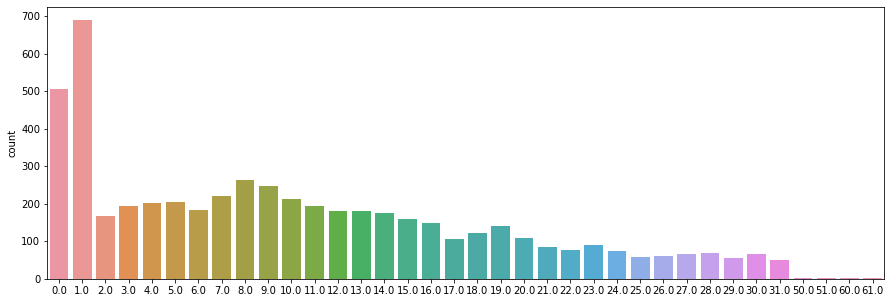

In [13]:
plot_features('Tenure')


## % Customers churned in months

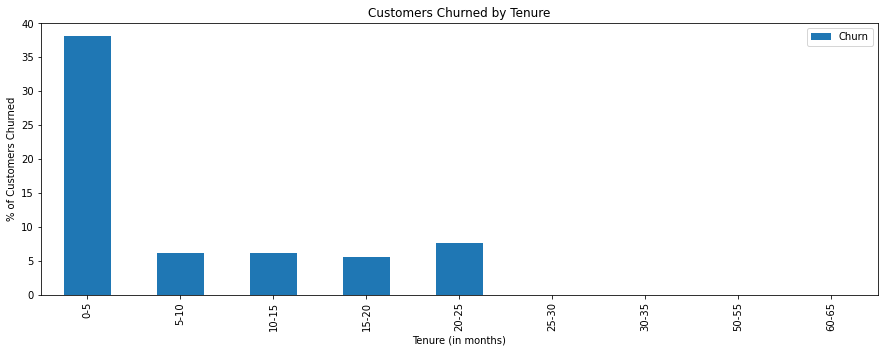

In [14]:
data_copy=data.copy().to_pandas()
data_copy['tenure_bin']=pd.cut(data_copy['Tenure'],13,labels=["0-5","5-10","10-15","15-20","20-25","25-30","30-35","35-40","40-45","45-50","50-55","55-60","60-65"])
churn_plot('tenure_bin','Churn',data_copy)

## Days since last order

/opt/anaconda3/lib/python3.8/site-packages/pyspark/pandas/indexing.py:1349: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if label == key or label[0] == key:


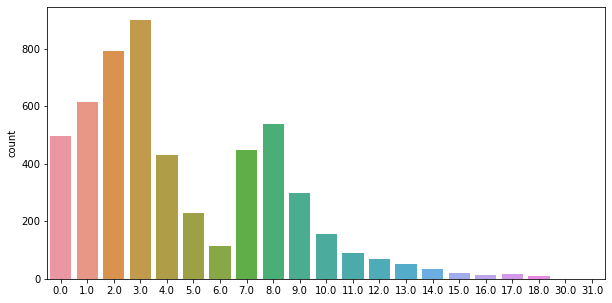

In [15]:
plot_features('DaySinceLastOrder')

## % of Customers churned by day since last order

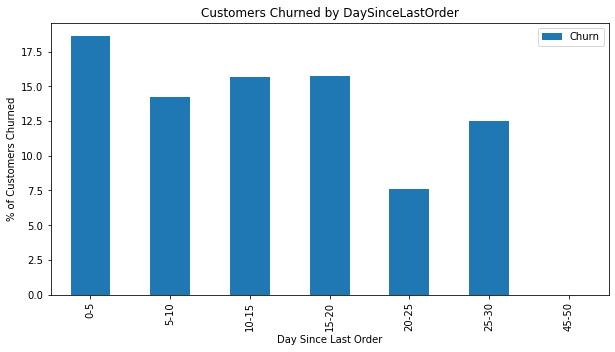

In [16]:
data_copy['lastorder_bin']=pd.cut(data_copy['DaySinceLastOrder'],10,labels=["0-5","5-10","10-15","15-20","20-25","25-30","30-35","35-40","40-45","45-50"])
churn_plot('lastorder_bin','Churn',data_copy)


## Satisfaction score

/opt/anaconda3/lib/python3.8/site-packages/pyspark/pandas/indexing.py:1349: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if label == key or label[0] == key:


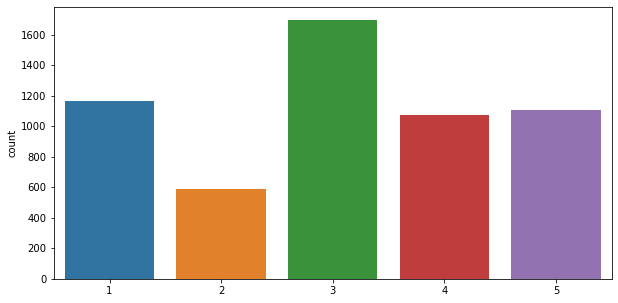

In [17]:
plot_features('SatisfactionScore')

## % customers churned by Satisfaction Score

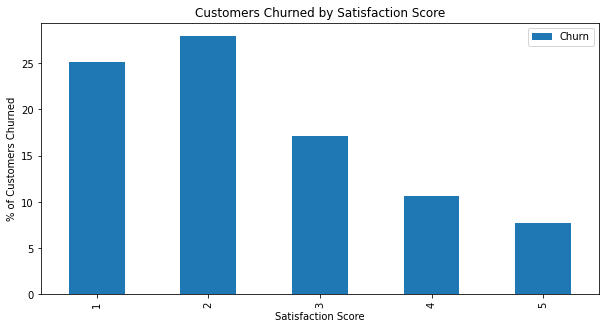

In [18]:
churn_plot('SatisfactionScore','Churn',data.to_pandas())


## Customer churn analysis based on hours spend on app

<Figure size 1440x864 with 0 Axes>

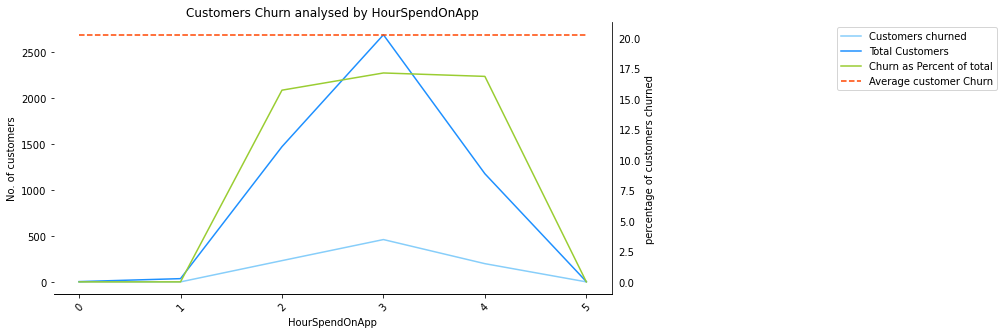

In [19]:
analysis_chart('HourSpendOnApp')

## Customer churn analysis based on Marital Status

<Figure size 1440x864 with 0 Axes>

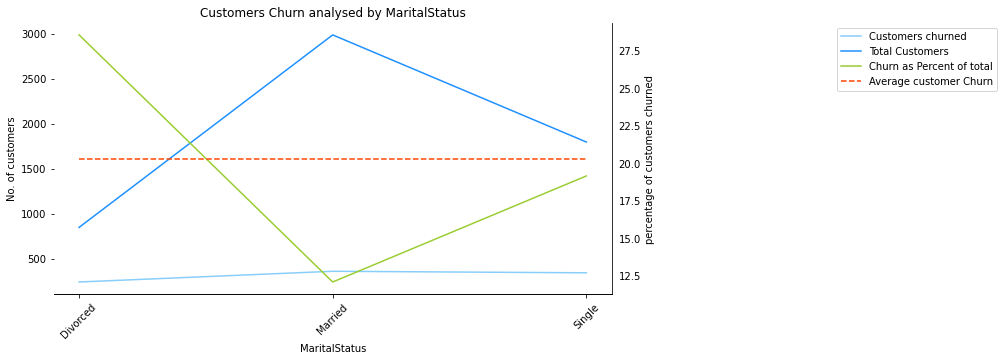

In [20]:
analysis_chart('MaritalStatus')

## Customer churn analysis based on gender

<Figure size 1440x864 with 0 Axes>

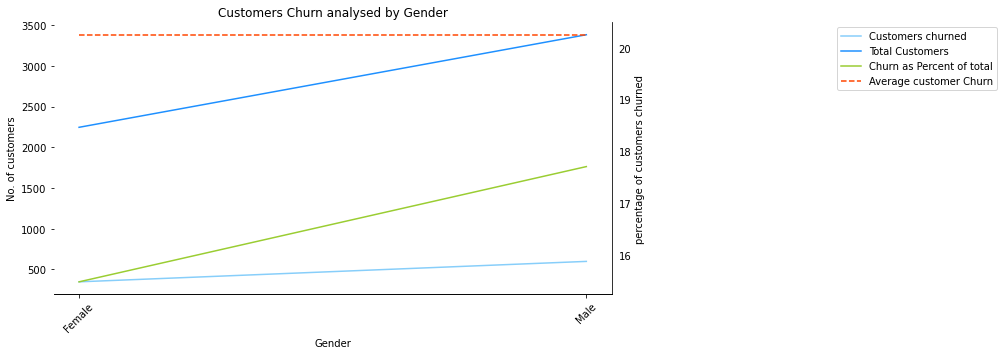

In [21]:
analysis_chart('Gender')

### Does preferred login device show any churning pattern?

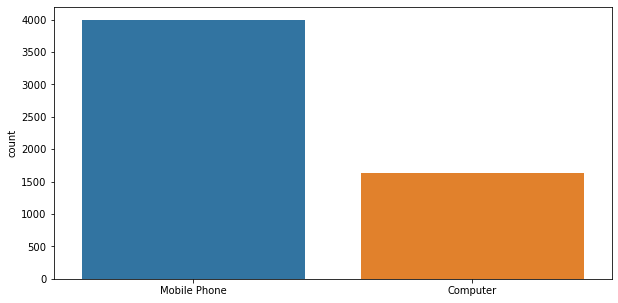

In [22]:
plot_features('PreferredLoginDevice')

## % Customers churned based on Preferred Login Device

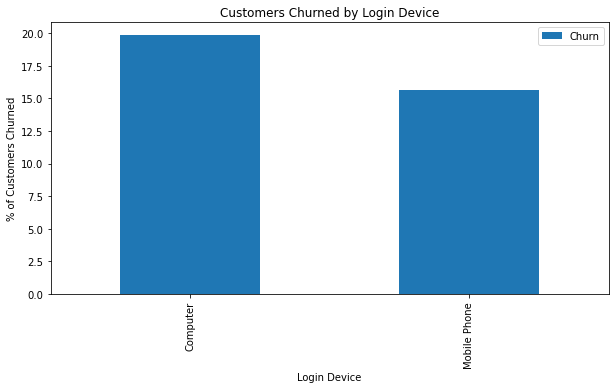

In [23]:

churn_plot('PreferredLoginDevice','Churn',data.to_pandas())

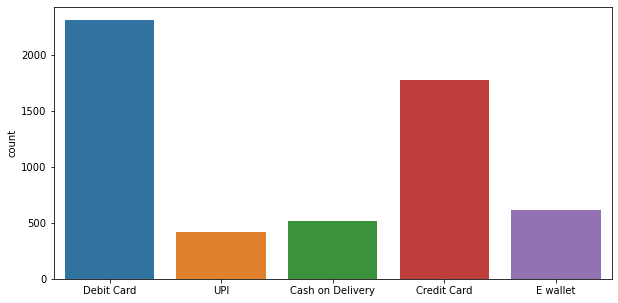

In [24]:
plot_features('PreferredPaymentMode')

## % of customers churned based on payment methods

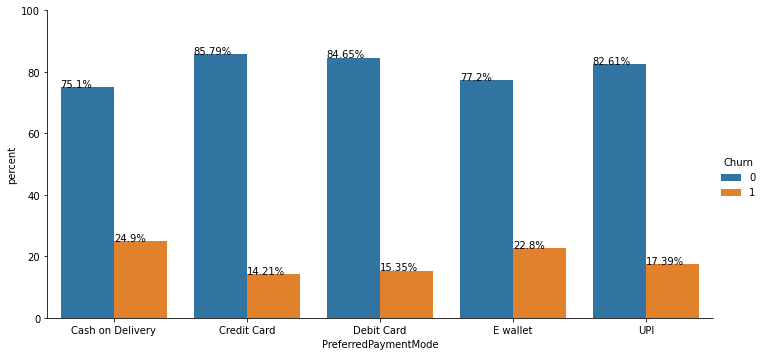

In [25]:
plot_catplot('PreferredPaymentMode','Churn')

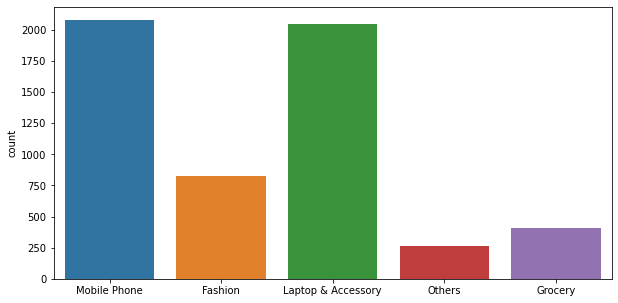

In [26]:
plot_features('PreferedOrderCat')


## % of customers churned based on prefered order category

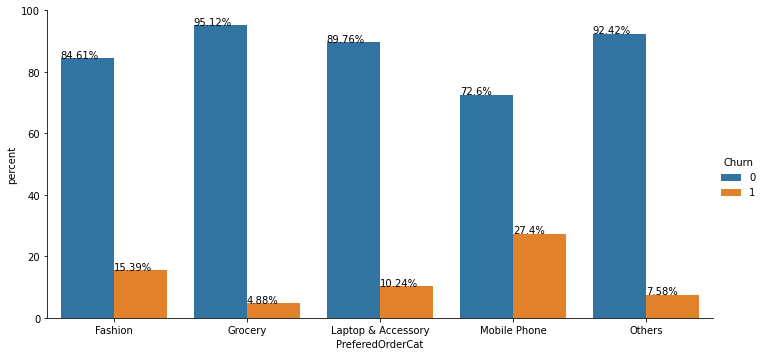

In [27]:
plot_catplot('PreferedOrderCat','Churn')



/opt/anaconda3/lib/python3.8/site-packages/pyspark/pandas/indexing.py:1349: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if label == key or label[0] == key:


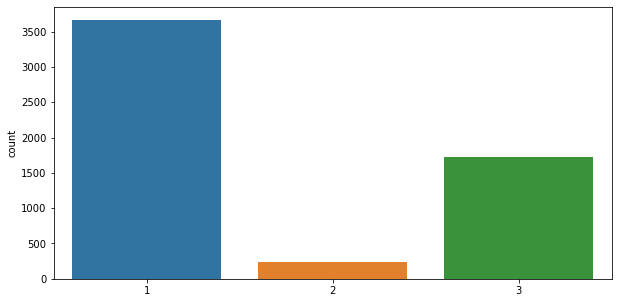

In [28]:
plot_features('CityTier')

## % of customers churned based on City tier

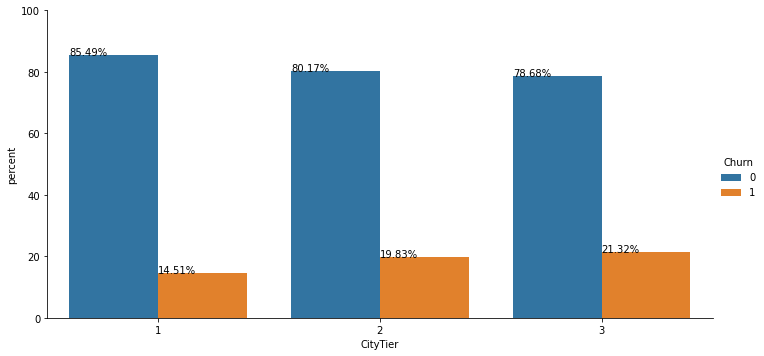

In [29]:
plot_catplot('CityTier','Churn')

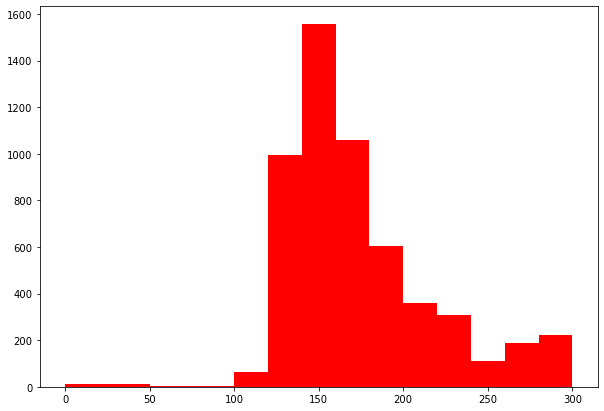

In [30]:
a = data_new['CashbackAmount']
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(a, bins = [0, 50, 100, 120,140,160,180,200,220,240,260,280,300],color = "red")
plt.show()

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.1 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarn

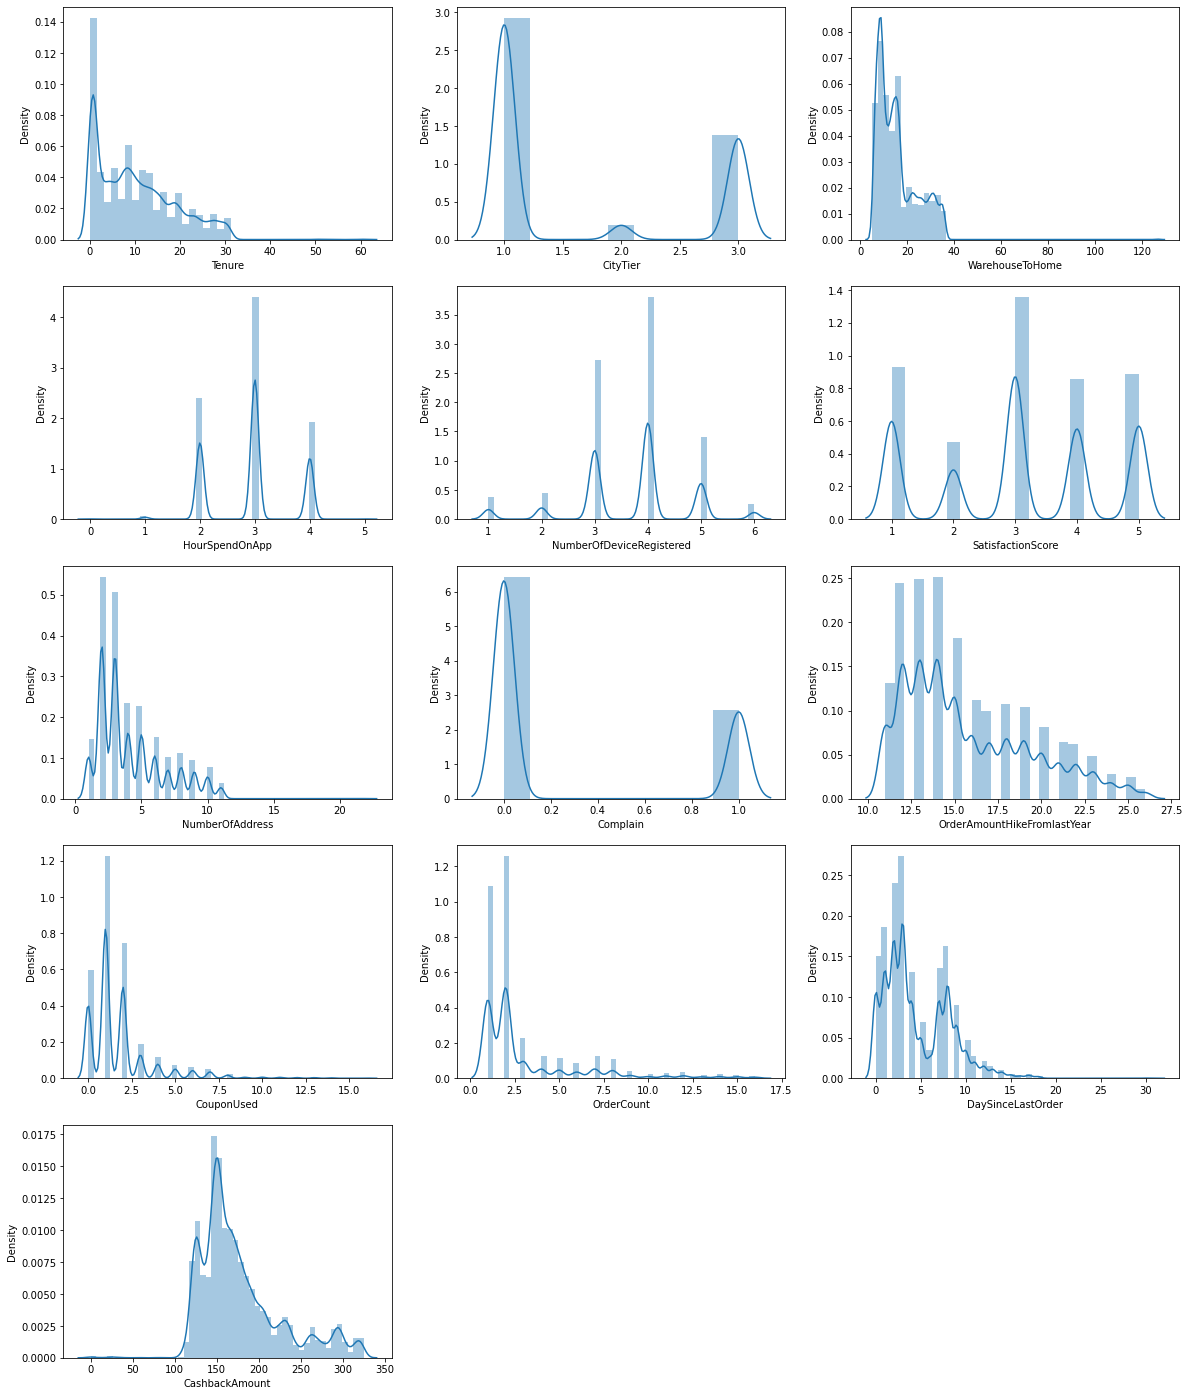

In [31]:
col_list=['Tenure', 'PreferredLoginDevice', 'CityTier',
       'WarehouseToHome', 'PreferredPaymentMode', 'Gender', 'HourSpendOnApp',
       'NumberOfDeviceRegistered', 'PreferedOrderCat', 'SatisfactionScore',
       'MaritalStatus', 'NumberOfAddress', 'Complain',
       'OrderAmountHikeFromlastYear', 'CouponUsed', 'OrderCount',
       'DaySinceLastOrder', 'CashbackAmount']

data_new=data[col_list].to_pandas()

# Distplot
cont=data_new.dtypes[(data_new.dtypes!='object')].index
plt.figure(figsize=(20,30))
for i,j in zip(range(1,len(cont)+1),cont):
    plt.subplot(6,3,i)
    sns.distplot(data_new[j],kde_kws={'bw':0.1})

# Data pre-processing

<font size="3"><div class="alert alert-block alert-success">
- Performed Data pre-processing before building machine learning models

#### Steps performed:
- Checking null values and replacing missing value by performing median imputation.
- Outlier detection and removing of outlier
- Multicollinearity using VIF for logistic regression model
- One hot encoding for binary features using min max scaler
    
#### Outcome:
- Clean dataset and better results and performance by our models
    
</div></font>

In [32]:
# Check for missing values
data.isnull().sum()

Churn                            0
Tenure                         264
PreferredLoginDevice             0
CityTier                         0
WarehouseToHome                251
PreferredPaymentMode             0
Gender                           0
HourSpendOnApp                 255
NumberOfDeviceRegistered         0
PreferedOrderCat                 0
SatisfactionScore                0
MaritalStatus                    0
NumberOfAddress                  0
Complain                         0
OrderAmountHikeFromlastYear    265
CouponUsed                     256
OrderCount                     258
DaySinceLastOrder              307
CashbackAmount                   0
dtype: int64

In [33]:
# Replace missing values with median
data= data.to_pandas()
imputer=SimpleImputer(missing_values=np.nan,strategy='median')
imputer=imputer.fit(data[cont].iloc[:,:])
data[cont]=imputer.transform(data[cont])

In [34]:
# Check again for missing value after replacing
data.isnull().sum()

Churn                          0
Tenure                         0
PreferredLoginDevice           0
CityTier                       0
WarehouseToHome                0
PreferredPaymentMode           0
Gender                         0
HourSpendOnApp                 0
NumberOfDeviceRegistered       0
PreferedOrderCat               0
SatisfactionScore              0
MaritalStatus                  0
NumberOfAddress                0
Complain                       0
OrderAmountHikeFromlastYear    0
CouponUsed                     0
OrderCount                     0
DaySinceLastOrder              0
CashbackAmount                 0
dtype: int64

## Outlier treatment

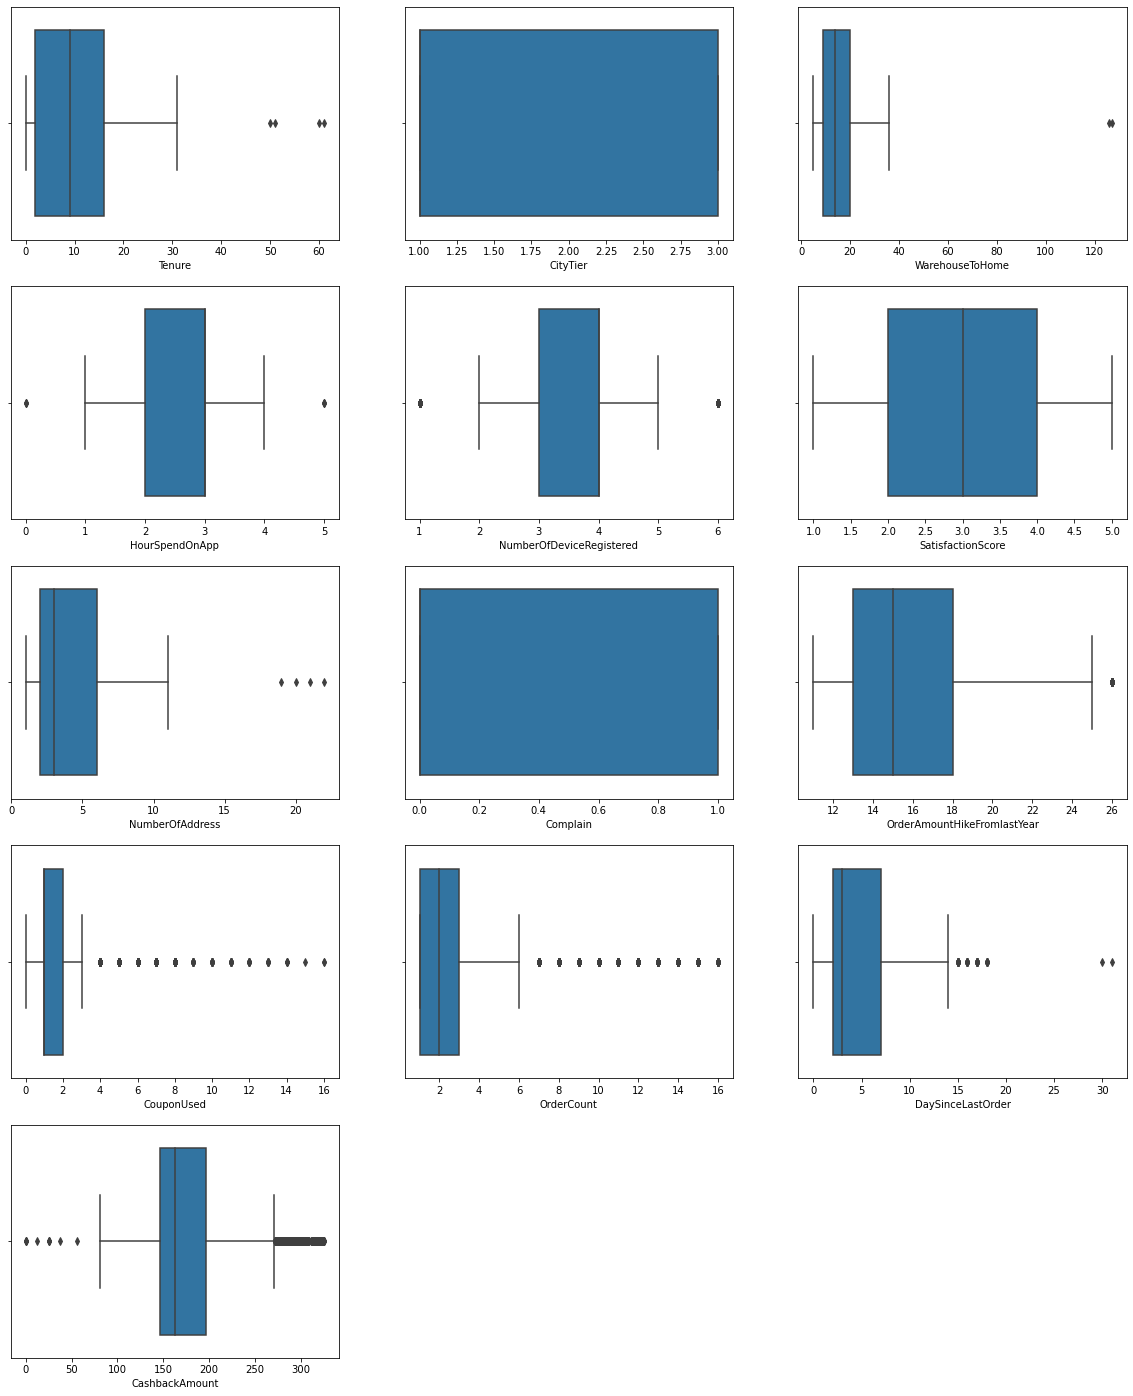

In [35]:
cont=data_new.dtypes[(data_new.dtypes!='object')].index
plt.figure(figsize=(20,30))
for i,j in zip(range(1,len(cont)+1),cont):
    plt.subplot(6,3,i)
    sns.boxplot(x=data_new[j])

In [36]:
def remove_outlier(col):
    sorted(col)
    Q1,Q3=np.percentile(col,[25,75])
    IQR=Q3-Q1
    lower_range= Q1-(1.5 * IQR)
    upper_range= Q3+(1.5 * IQR)
    return lower_range, upper_range

In [37]:
for column in col_list:
    if data[column].dtype != 'object': 
        lr,ur=remove_outlier(data[column])
        data[column]=np.where(data[column]>ur,ur,data[column])
        data[column]=np.where(data[column]<lr,lr,data[column])

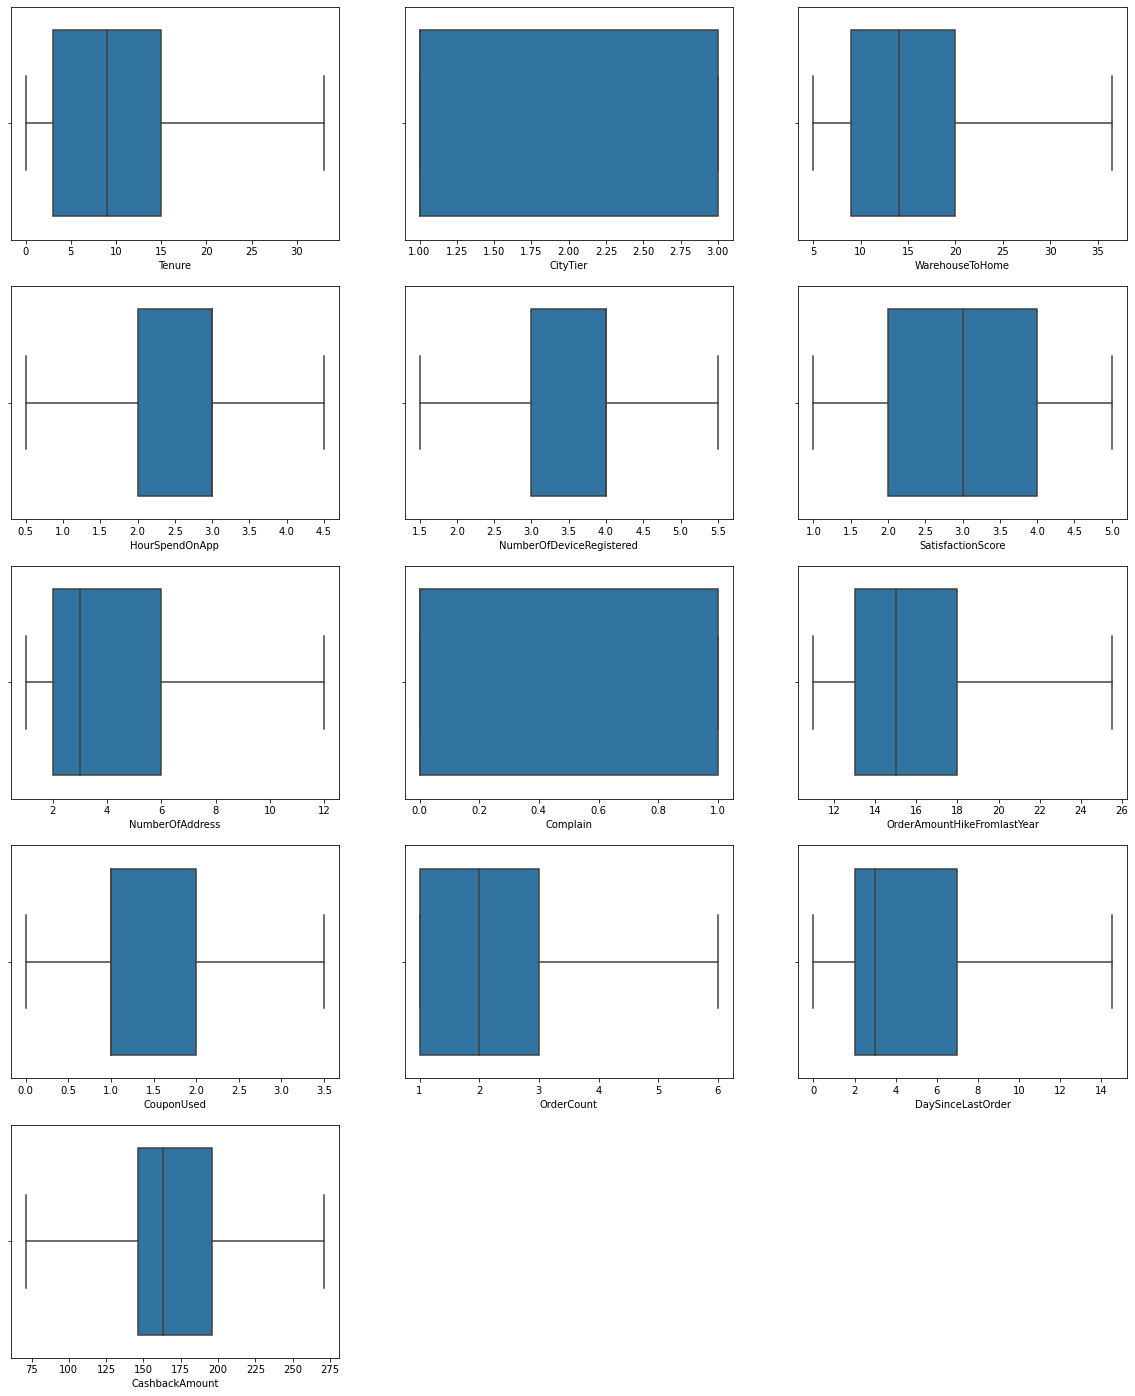

In [38]:
cont=data_new.dtypes[(data_new.dtypes!='object')].index
plt.figure(figsize=(20,30))
for i,j in zip(range(1,len(cont)+1),cont):
    plt.subplot(6,3,i)
    sns.boxplot(x=data[j])

## Variable transformation

In [39]:
cat_cols=['PreferredLoginDevice','PreferredPaymentMode','Gender','PreferedOrderCat','MaritalStatus']

In [40]:
# One-hot Encoding
data=pd.get_dummies(data,columns=cat_cols,drop_first=True)

col_list=['Tenure', 'CityTier', 'WarehouseToHome', 'HourSpendOnApp',
       'NumberOfDeviceRegistered', 'SatisfactionScore', 'NumberOfAddress',
       'Complain', 'OrderAmountHikeFromlastYear', 'CouponUsed', 'OrderCount',
       'DaySinceLastOrder', 'CashbackAmount',
       'PreferredLoginDevice_Mobile Phone', 'PreferredPaymentMode_Credit Card',
       'PreferredPaymentMode_Debit Card', 'PreferredPaymentMode_E wallet',
       'PreferredPaymentMode_UPI', 'Gender_Male', 'PreferedOrderCat_Grocery',
       'PreferedOrderCat_Laptop & Accessory', 'PreferedOrderCat_Mobile Phone',
       'PreferedOrderCat_Others', 'MaritalStatus_Married',
       'MaritalStatus_Single']

In [41]:

mm_scaler = preprocessing.MinMaxScaler()
data[col_list] = mm_scaler.fit_transform(data[col_list])

## Multicollinearity using VIF

<font size="3"><div class="alert alert-block alert-success">

Multicollinearity occurs when two or more independent variables are highly correlated with one another in a
regression model. 

Checked multicollinearity using Variation Inflation Factor (VIF). Larger the VIF value less reliable our regression results are.

The following variables were removed that had a VIF value of greater than 5(threshold):
1. CashbackAmount
2. HourSpendOnApp
3. NumberOfDeviceRegistered
    
</div></font>

In [42]:
def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

In [43]:
X_reg=data.drop('Churn',axis=1)
calc_vif(X_reg).sort_values(by = 'VIF', ascending = False).round(2)

,variables,VIF
3,HourSpendOnApp,13.70
12,CashbackAmount,8.23
4,NumberOfDeviceRegistered,7.03
9,CouponUsed,5.05
15,PreferredPaymentMode_Debit Card,4.71
23,MaritalStatus_Married,4.09
14,PreferredPaymentMode_Credit Card,3.85
10,OrderCount,3.61
11,DaySinceLastOrder,3.58
21,PreferedOrderCat_Mobile Phone,3.34


In [44]:
X_reg=X_reg.drop('CashbackAmount',axis=1)
calc_vif(X_reg).sort_values(by = 'VIF', ascending = False).round(2)

,variables,VIF
3,HourSpendOnApp,13.48
4,NumberOfDeviceRegistered,6.93
9,CouponUsed,5.04
14,PreferredPaymentMode_Debit Card,4.65
22,MaritalStatus_Married,4.08
13,PreferredPaymentMode_Credit Card,3.80
10,OrderCount,3.57
20,PreferedOrderCat_Mobile Phone,3.34
11,DaySinceLastOrder,3.32
12,PreferredLoginDevice_Mobile Phone,3.31


In [45]:
X_reg=X_reg.drop('HourSpendOnApp',axis=1)
calc_vif(X_reg).sort_values(by = 'VIF', ascending = False).round(2)

,variables,VIF
3,NumberOfDeviceRegistered,5.88
8,CouponUsed,4.98
13,PreferredPaymentMode_Debit Card,4.50
21,MaritalStatus_Married,4.03
12,PreferredPaymentMode_Credit Card,3.71
9,OrderCount,3.57
10,DaySinceLastOrder,3.31
11,PreferredLoginDevice_Mobile Phone,3.27
0,Tenure,3.22
19,PreferedOrderCat_Mobile Phone,3.16


In [46]:
X_reg=X_reg.drop('NumberOfDeviceRegistered',axis=1)
calc_vif(X_reg).sort_values(by = 'VIF', ascending = False).round(2)

,variables,VIF
7,CouponUsed,4.86
12,PreferredPaymentMode_Debit Card,4.38
20,MaritalStatus_Married,3.97
11,PreferredPaymentMode_Credit Card,3.62
8,OrderCount,3.57
9,DaySinceLastOrder,3.30
10,PreferredLoginDevice_Mobile Phone,3.25
0,Tenure,3.20
3,SatisfactionScore,3.13
17,PreferedOrderCat_Laptop & Accessory,3.09


In [47]:
X=data.drop('Churn',axis=1)
y=data.pop('Churn')

<font size="3"><div class="alert alert-block alert-success">
Dividing the data into testing(20%) and training(80%) dataset
</div></font>

In [48]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.20,random_state=1)


In [49]:
X_train_reg=X_train.copy()
X_test_reg=X_test.copy()

# Building Predictive Models

# Logistic Regression

<font size="3"><div class="alert alert-block alert-success">
- Logit function is used to identify the significant variables that can be used for modelling.
- We have run 6 iterations with Logit function to identify the significant variables.
- Out of total 22 variables 17 variables have been identified for modelling

### Outcome:

- Accuracy :               0.86
- AUC (Area under curve) : 0.87
- Precision :              0.57
- Recall  :               0.49
- F1 score :              0.53

Eventough logistic regression has good Accuracy and AUC score, as dataset is slightly imbalanced so f1 score(harmonic mean of Precision and Recall) is given more weightage in checking the performance of the model which is quite low in case of logistic regression.
    
</div></font>

In [50]:
X_train_reg = X_train_reg.drop(columns=['CashbackAmount','HourSpendOnApp','NumberOfDeviceRegistered'],axis=1)
X_test_reg = X_test_reg.drop(columns=['CashbackAmount','HourSpendOnApp','NumberOfDeviceRegistered'],axis=1)

#Statsmodel requires the labelled data, therefore, concatinating the y label to the train set.

Default_train = pd.concat([X_train_reg,y_train], axis=1)
Default_test = pd.concat([X_test_reg,y_test], axis=1)


Default_train_logreg=Default_train.copy()

Default_train_logreg=Default_train.copy()

Default_train_logreg=Default_train_logreg.rename(columns={"PreferredLoginDevice_Mobile Phone":"PreferredLoginDevice_MobilePhone","PreferredPaymentMode_Credit Card":"PreferredPaymentMode_CreditCard","PreferredPaymentMode_Debit Card":"PreferredPaymentMode_DebitCard","PreferredPaymentMode_E wallet":"PreferredPaymentMode_Ewallet","PreferedOrderCat_Laptop & Accessory":"PreferedOrderCat_Laptop_Accessory","PreferedOrderCat_Mobile Phone":"PreferedOrderCat_MobilePhone"})
Default_test_logreg=Default_test.rename(columns={"PreferredLoginDevice_Mobile Phone":"PreferredLoginDevice_MobilePhone","PreferredPaymentMode_Credit Card":"PreferredPaymentMode_CreditCard","PreferredPaymentMode_Debit Card":"PreferredPaymentMode_DebitCard","PreferredPaymentMode_E wallet":"PreferredPaymentMode_Ewallet","PreferedOrderCat_Laptop & Accessory":"PreferedOrderCat_Laptop_Accessory","PreferedOrderCat_Mobile Phone":"PreferedOrderCat_MobilePhone"})
Default_test_logreg

,Tenure,CityTier,WarehouseToHome,SatisfactionScore,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,...,PreferredPaymentMode_Ewallet,PreferredPaymentMode_UPI,Gender_Male,PreferedOrderCat_Grocery,PreferedOrderCat_Laptop_Accessory,PreferedOrderCat_MobilePhone,PreferedOrderCat_Others,MaritalStatus_Married,MaritalStatus_Single,Churn
5239,0.303030,1.0,0.158730,0.75,0.818182,0.0,0.137931,0.285714,1.0,0.137931,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0
1660,0.030303,1.0,0.349206,1.00,0.272727,0.0,0.758621,0.285714,0.2,0.344828,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0
2106,0.424242,0.0,0.126984,1.00,0.272727,0.0,0.137931,0.857143,0.2,0.620690,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0
4580,0.030303,0.0,0.222222,0.75,0.545455,0.0,0.413793,0.571429,0.2,0.137931,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0
566,0.030303,0.0,0.857143,0.75,0.727273,1.0,0.206897,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11,0.333333,0.0,0.031746,0.50,0.818182,1.0,0.137931,0.000000,0.0,0.000000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1
17,0.000000,1.0,0.190476,0.50,0.090909,1.0,0.000000,0.285714,0.0,0.206897,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1
1573,0.242424,1.0,0.031746,0.50,0.090909,0.0,0.206897,0.285714,0.0,0.551724,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
2233,0.757576,0.0,0.634921,0.25,0.272727,0.0,0.275862,0.285714,0.0,0.413793,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0


<font size="3"><div class="alert alert-block alert-success">
Running logit function in 6 iteration to get significant variables
</div></font>

In [51]:
model_1 = SM.logit(formula = 'Churn ~ Tenure + CityTier + WarehouseToHome + SatisfactionScore + NumberOfAddress + Complain + OrderAmountHikeFromlastYear + CouponUsed + OrderCount + DaySinceLastOrder  + PreferredLoginDevice_MobilePhone + PreferredPaymentMode_CreditCard + PreferredPaymentMode_DebitCard + PreferredPaymentMode_Ewallet + PreferredPaymentMode_UPI  + Gender_Male + PreferedOrderCat_Grocery + PreferedOrderCat_Laptop_Accessory + PreferedOrderCat_MobilePhone + PreferedOrderCat_Others + MaritalStatus_Married + MaritalStatus_Single', data=Default_train_logreg).fit()

model_2 = SM.logit(formula = 'Churn ~ Tenure + CityTier + WarehouseToHome + SatisfactionScore + NumberOfAddress + Complain + OrderAmountHikeFromlastYear + OrderCount + DaySinceLastOrder  + PreferredLoginDevice_MobilePhone + PreferredPaymentMode_CreditCard + PreferredPaymentMode_DebitCard + PreferredPaymentMode_Ewallet + PreferredPaymentMode_UPI  + Gender_Male + PreferedOrderCat_Grocery + PreferedOrderCat_Laptop_Accessory + PreferedOrderCat_MobilePhone + PreferedOrderCat_Others + MaritalStatus_Married + MaritalStatus_Single', data=Default_train_logreg).fit()

model_3 = SM.logit(formula = 'Churn ~ Tenure + CityTier + WarehouseToHome + SatisfactionScore + NumberOfAddress + Complain + OrderAmountHikeFromlastYear + OrderCount + DaySinceLastOrder  + PreferredLoginDevice_MobilePhone + PreferredPaymentMode_CreditCard + PreferredPaymentMode_DebitCard + PreferredPaymentMode_UPI  + Gender_Male + PreferedOrderCat_Grocery + PreferedOrderCat_Laptop_Accessory + PreferedOrderCat_MobilePhone + PreferedOrderCat_Others + MaritalStatus_Married + MaritalStatus_Single', data=Default_train_logreg).fit()

model_4 = SM.logit(formula = 'Churn ~ Tenure + CityTier + WarehouseToHome + SatisfactionScore + NumberOfAddress + Complain + OrderAmountHikeFromlastYear + OrderCount + DaySinceLastOrder  + PreferredLoginDevice_MobilePhone + PreferredPaymentMode_CreditCard + PreferredPaymentMode_DebitCard + PreferredPaymentMode_UPI  + Gender_Male + PreferedOrderCat_Grocery + PreferedOrderCat_Laptop_Accessory + PreferedOrderCat_Others + MaritalStatus_Married + MaritalStatus_Single', data=Default_train_logreg).fit()

model_5 = SM.logit(formula = 'Churn ~ Tenure + CityTier + WarehouseToHome + SatisfactionScore + NumberOfAddress + Complain + OrderCount + DaySinceLastOrder  + PreferredLoginDevice_MobilePhone + PreferredPaymentMode_CreditCard + PreferredPaymentMode_DebitCard + PreferredPaymentMode_UPI  + Gender_Male + PreferedOrderCat_Grocery + PreferedOrderCat_Laptop_Accessory + PreferedOrderCat_Others + MaritalStatus_Married + MaritalStatus_Single', data=Default_train_logreg).fit()

model_6 = SM.logit(formula = 'Churn ~ Tenure + CityTier + WarehouseToHome + SatisfactionScore + NumberOfAddress + Complain + OrderCount + DaySinceLastOrder  + PreferredLoginDevice_MobilePhone + PreferredPaymentMode_CreditCard + PreferredPaymentMode_DebitCard + PreferredPaymentMode_UPI  + Gender_Male + PreferedOrderCat_Laptop_Accessory + PreferedOrderCat_Others + MaritalStatus_Married + MaritalStatus_Single', data=Default_train_logreg).fit()

Optimization terminated successfully.
         Current function value: 0.317062
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.317065
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.317094
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.317153
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.318047
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.318062
         Iterations 8


In [52]:
model_6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  Churn   No. Observations:                 4503
Model:                          Logit   Df Residuals:                     4485
Method:                           MLE   Df Model:                           17
Date:                Fri, 13 May 2022   Pseudo R-squ.:                  0.2875
Time:                        10:18:51   Log-Likelihood:                -1432.2
converged:                       True   LL-Null:                       -2010.3
Covariance Type:            nonrobust   LLR p-value:                3.454e-235
=====================================================================================================
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                             1.2903      0.235      5.492      0.000       0.830       1.751
Tenure                               -6.2704      0.322    -19.446      0.000      -6.902      -5.638
CityTier                              0.4892      0.114      4.308      0.000       0.267       0.712
WarehouseToHome                       1.0508      0.185      5.674      0.000       0.688       1.414
SatisfactionScore                    -1.4372      0.144     -9.973      0.000      -1.720      -1.155
NumberOfAddress                       0.7246      0.200      3.619      0.000       0.332       1.117
Complain                              0.5823      0.100      5.848      0.000       0.387       0.777
OrderCount                            0.1977      0.158      1.248      0.212      -0.113       0.508
DaySinceLastOrder                    -0.5959      0.237     -2.510      0.012      -1.061      -0.131
PreferredLoginDevice_MobilePhone     -0.3008      0.102     -2.959      0.003      -0.500      -0.102
PreferredPaymentMode_CreditCard      -0.6625      0.139     -4.752      0.000      -0.936      -0.389
PreferredPaymentMode_DebitCard       -0.5793      0.131     -4.425      0.000      -0.836      -0.323
PreferredPaymentMode_UPI             -0.4541      0.199     -2.279      0.023      -0.845      -0.064
Gender_Male                           0.0781      0.098      0.793      0.428      -0.115       0.271
PreferedOrderCat_Laptop_Accessory    -1.2717      0.117    -10.889      0.000      -1.501      -1.043
PreferedOrderCat_Others               0.9527      0.300      3.178      0.001       0.365       1.540
MaritalStatus_Married                -1.3060      0.128    -10.222      0.000      -1.556      -1.056
MaritalStatus_Single                 -0.5781      0.130     -4.462      0.000      -0.832      -0.324
=====================================================================================================
"""

In [53]:
y_prob_pred_test = model_6.predict(Default_test_logreg)
ytest_pred_logreg=[]

for i in range(0,len(y_prob_pred_test)):
    if np.array(y_prob_pred_test)[i]>0.37:
        a=1
    else:
        a=0
    ytest_pred_logreg.append(a)

In [54]:
def logistic_regression_confusion_matrix():
    sns.heatmap((confusion_matrix(Default_test_logreg['Churn'],ytest_pred_logreg)),annot=True,fmt='.5g'
                ,cmap='Blues');
    plt.xlabel('Predicted');
    plt.ylabel('Actuals',rotation=0);

In [55]:
def logistic_regression_accuracy():
    logistic_test_score=accuracy_score(y_test,ytest_pred_logreg)
    return logistic_test_score

In [56]:
def logistic_regression_clsf_report():
    print(classification_report(Default_test_logreg['Churn'],ytest_pred_logreg,digits=2))

In [57]:
def logistic_regression_ROC():
    # predict probabilities
    probs = model_6.predict(Default_test_logreg)

    # calculate AUC
    logistic_test_auc = roc_auc_score(y_test, probs)
    print('AUC: %.2f' % logistic_test_auc)

    # calculate roc curve
    logistic_test_fpr, logistic_test_tpr, train_thresholds = roc_curve(y_test, probs)
    plt.plot([0, 1], [0, 1], linestyle='--')

    # plot the roc curve for the model
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.plot(logistic_test_fpr, logistic_test_tpr,label='Logistic Regression (area = '+str(logistic_test_auc.round(2))+')')
    plt.legend(loc=4)
    plt.show()
    return logistic_test_auc,logistic_test_fpr, logistic_test_tpr

In [58]:
def logistic_metrics():
    logistic_metrics=classification_report(Default_test_logreg['Churn'],ytest_pred_logreg,output_dict=True)
    df=pd.DataFrame(logistic_metrics).transpose()
    logistic_test_precision=round(df.loc["1"][0],2)
    logistic_test_recall=round(df.loc["1"][1],2)
    logistic_test_f1=round(df.loc["1"][2],2)
    print ('logistic_test_precision ',logistic_test_precision)
    print ('logistic_test_recall ',logistic_test_recall)
    print ('logistic_test_f1 ',logistic_test_f1)
    return logistic_test_precision,logistic_test_recall,logistic_test_f1

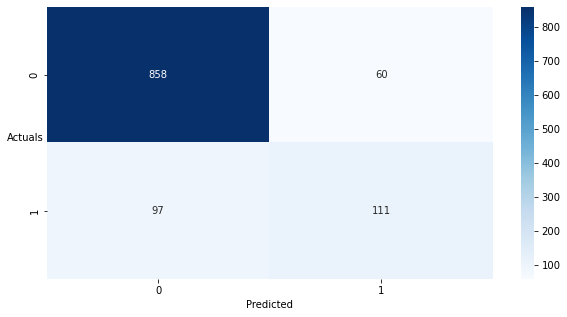

In [59]:
logistic_regression_confusion_matrix()

<font size="3"><div class="alert alert-block alert-success">
From above metrics we can observe that it has predicted 111 customers correctly that are going to churn out of total 208 churned customers
</div></font>

In [60]:
logistic_test_score = logistic_regression_accuracy()

<font size="3"><div class="alert alert-block alert-success">
Printing classification report of logistic regression
</div></font>

In [61]:
logistic_regression_clsf_report()

              precision    recall  f1-score   support

           0       0.90      0.93      0.92       918
           1       0.65      0.53      0.59       208

    accuracy                           0.86      1126
   macro avg       0.77      0.73      0.75      1126
weighted avg       0.85      0.86      0.86      1126



<font size="3"><div class="alert alert-block alert-success">
Printing Receiver Operating Characteristic Curve (ROC) of logistic regression
</div></font>


AUC: 0.86


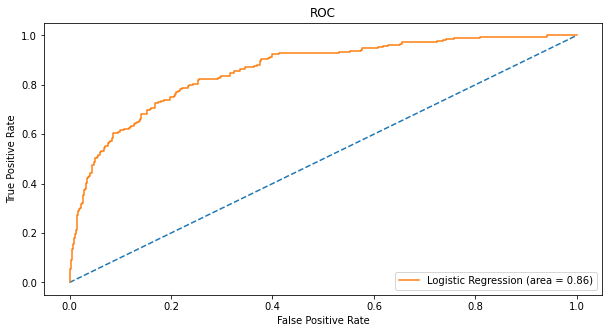

In [62]:
logistic_test_auc,logistic_test_fpr,logistic_test_tpr = logistic_regression_ROC()

<font size="3"><div class="alert alert-block alert-success">
Printing precision, recall and f1 score of logistic regression
</div></font>

In [63]:
logistic_test_precision,logistic_test_recall,logistic_test_f1 = logistic_metrics()

logistic_test_precision  0.65
logistic_test_recall  0.53
logistic_test_f1  0.59


## Decision Tree

<font size="3"><div class="alert alert-block alert-success">
- Feature importance value of all the variables are calculated and least important feature is removed.
- Grid search is used to hypertune the parameters of the model to get better results.
<br>  
    
#### The top three features according to decision tree model are:
- Tenure (27%)
- CashbackAmount(10%)
- WarehouseToHome (8%)
    



### Outcome:

#### Without grid search
- Accuracy :               87%
- AUC (Area under curve) : 0.78
- Precision :              67%
- Recall  :               65%
- F1 score :              66%

#### With grid search
- Accuracy :               88%
- AUC (Area under curve) : 0.87
- Precision :              74%
- Recall  :               55%
- F1 score :              63%
    
    
#### From above results we can see that with Grid search overall result of the model has been improved also, decision tree model has given better performance as compared to logistic regression model.
    
</div></font>

In [64]:

dt_model = DecisionTreeClassifier(criterion = 'gini',random_state=0)
dt_model.fit(X_train,y_train)


DecisionTreeClassifier(random_state=0)

In [65]:


train_char_label = ['No', 'Yes']

Customer_Churn_Tree_File = open('customer_churn_tree.dot','w')

dot_data = tree.export_graphviz(dt_model, out_file=Customer_Churn_Tree_File, feature_names = list(X_train), class_names = list(train_char_label))

Customer_Churn_Tree_File.close()

feature_imp=pd.DataFrame(dt_model.feature_importances_, columns = ["Imp"], index = X_train.columns).sort_values(by='Imp',ascending=False)



<font size="3"><div class="alert alert-block alert-success">
Bar plot of important features
</div></font>

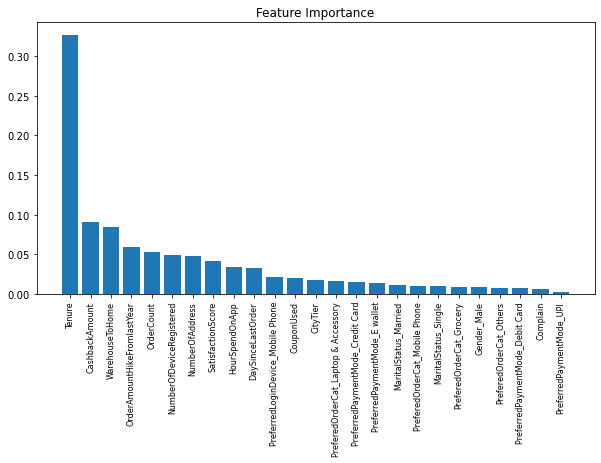

In [66]:
importances=dt_model.feature_importances_
indices = np.argsort(importances)[::-1]

names = [data.columns[i] for i in indices]
# Barplot: Add bars
plt.bar(range(X.shape[1]), importances[indices])
# Add feature names as x-axis labels
plt.xticks(range(X.shape[1]), names, rotation=90, fontsize = 8)
# Create plot title
plt.title("Feature Importance")
# Show plot
plt.show()

<font size="3"><div class="alert alert-block alert-success">
It can be oserved that Tenure, cashbackAmount and WarehouseToHome are the top 3 importatnt features
</div></font>

In [67]:
ytest_predict_dt = dt_model.predict(X_test)

In [68]:
def decision_tree_clf_report():
    print(classification_report(y_test,ytest_predict_dt))

In [69]:
feature_imp

,Imp
Tenure,0.326511
CashbackAmount,0.091031
WarehouseToHome,0.084634
OrderAmountHikeFromlastYear,0.059409
OrderCount,0.052734
NumberOfDeviceRegistered,0.049394
NumberOfAddress,0.048002
SatisfactionScore,0.042256
HourSpendOnApp,0.033902
DaySinceLastOrder,0.033342


<font size="3"><div class="alert alert-block alert-success">
Taking only important features to train our decision tree model
</div></font>


In [70]:
X_train_dt = X_train[['Tenure','CashbackAmount','DaySinceLastOrder','NumberOfAddress','WarehouseToHome','Complain','OrderAmountHikeFromlastYear','SatisfactionScore']]

X_test_dt = X_test[['Tenure','CashbackAmount','DaySinceLastOrder','NumberOfAddress','WarehouseToHome','Complain','OrderAmountHikeFromlastYear','SatisfactionScore']]

dt_model.fit(X_train_dt,y_train)

DecisionTreeClassifier(random_state=0)

In [71]:
feature_imp_1=pd.DataFrame(dt_model.feature_importances_, columns = ["Imp"], index = X_train_dt.columns)
feature_imp_1

,Imp
Tenure,0.331798
CashbackAmount,0.165707
DaySinceLastOrder,0.085159
NumberOfAddress,0.081501
WarehouseToHome,0.156871
Complain,0.023088
OrderAmountHikeFromlastYear,0.098029
SatisfactionScore,0.057849


<font size="3"><div class="alert alert-block alert-success">
Features taken to build the model based on their importance score
</div></font>

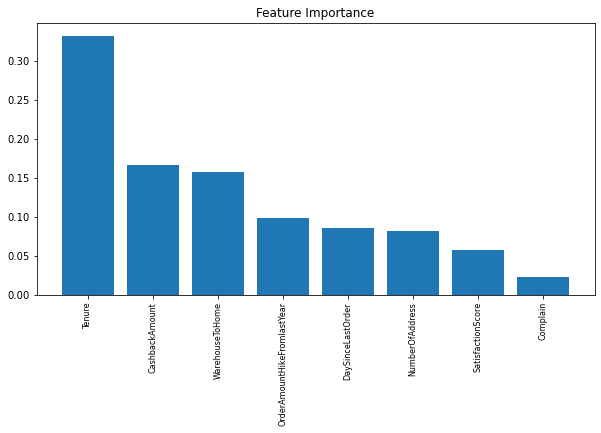

In [72]:
importances_1=dt_model.feature_importances_
indices_1 = np.argsort(importances_1)[::-1]
names_1 = [X_train_dt.columns[i] for i in indices_1]

# Barplot: Add bars
plt.bar(range(8), importances_1[indices_1])
# Add feature names as x-axis labels
plt.xticks(range(8), names_1, rotation=90, fontsize = 8)
# Create plot title
plt.title("Feature Importance")
# Show plot
plt.show()

In [73]:
ytest_predict_dt = dt_model.predict(X_test_dt)


In [74]:
def Decision_tree_confusion_matrix():
    sns.heatmap((confusion_matrix(y_test,ytest_predict_dt)),annot=True,fmt='.5g'
                ,cmap='Blues');
    plt.xlabel('Predicted');
    plt.ylabel('Actuals',rotation=0);

In [75]:
def Decision_tree_accuracy_score():
    dt_test_score=metrics.accuracy_score(y_test,ytest_predict_dt)
    return dt_test_score

In [76]:
def Decision_tree_clf_report():
    report=metrics.classification_report(y_test,ytest_predict_dt,digits=3,output_dict=True)
    df = pd.DataFrame(report).transpose()
    print(metrics.classification_report(y_test,ytest_predict_dt,digits=2))

In [77]:
def Decision_tree_ROC():
    # predict probabilities
    probs = dt_model.predict_proba(X_test_dt)
    # keep probabilities for the positive outcome only
    probs = probs[:, 1]
    # calculate AUC
    dt_test_auc = roc_auc_score(y_test, probs)
    print('AUC: %.3f' % dt_test_auc)
    # calculate roc curve
    dt_test_fpr, dt_test_tpr, train_thresholds = roc_curve(y_test, probs)
    plt.plot([0, 1], [0, 1], linestyle='--')
    # plot the roc curve for the model
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.plot(dt_test_fpr, dt_test_tpr)
    return dt_test_auc,dt_test_fpr,dt_test_tpr

In [78]:
def Decision_tree_matrices_score():
    dt_metrics=classification_report(y_test,ytest_predict_dt,output_dict=True)
    df=pd.DataFrame(dt_metrics).transpose()
    dt_test_precision=round(df.loc["1"][0],3)
    dt_test_recall=round(df.loc["1"][1],3)
    dt_test_f1=round(df.loc["1"][2],3)
    print ('dt_test_precision ',dt_test_precision)
    print ('dt_test_recall ',dt_test_recall)
    print ('dt_test_f1 ',dt_test_f1)
    return dt_test_precision,dt_test_recall,dt_test_f1

In [79]:
def DecisionT_GS_confusion_matrix():
    print(confusion_matrix(y_test,ytest_predict_dt_tuned))

In [80]:
def DecisionT_GS_clsf_report():
    print(classification_report(y_test,ytest_predict_dt_tuned))

In [81]:
def Decision_tree_GS_ROC():
    # predict probabilities
    probs = best_grid.predict_proba(X_test)
    # keep probabilities for the positive outcome only
    probs = probs[:, 1]
    # calculate AUC
    dt_test_auc = roc_auc_score(y_test, probs)
    print('AUC: %.2f' % dt_test_auc)
    # calculate roc curve
    dt_test_fpr, dt_test_tpr, train_thresholds = roc_curve(y_test, probs)
    plt.plot([0, 1], [0, 1], linestyle='--')
    # plot the roc curve for the model
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.plot(dt_test_fpr, dt_test_tpr,label='Decision Tree (area = '+str(dt_test_auc.round(2))+')')
    plt.legend(loc=4)
    plt.show()
    return dt_test_auc,dt_test_fpr, dt_test_tpr

<font size="3"><div class="alert alert-block alert-success">
Confusion matrix for decision tree
</font></div>

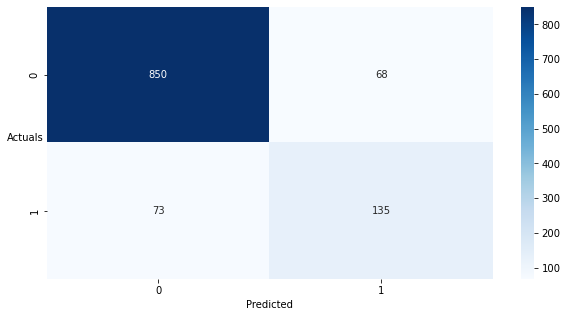

In [82]:
Decision_tree_confusion_matrix()

In [83]:
dt_test_score = Decision_tree_accuracy_score()

<font size="3"><div class="alert alert-block alert-success">
Printing classification report of decision tree
</font></div>

In [84]:
Decision_tree_clf_report()

              precision    recall  f1-score   support

           0       0.92      0.93      0.92       918
           1       0.67      0.65      0.66       208

    accuracy                           0.87      1126
   macro avg       0.79      0.79      0.79      1126
weighted avg       0.87      0.87      0.87      1126



<font size="3"><div class="alert alert-block alert-success">
Printing Receiver Operating Characteristic Curve (ROC) of decisoin tree model
</font></div>

AUC: 0.787


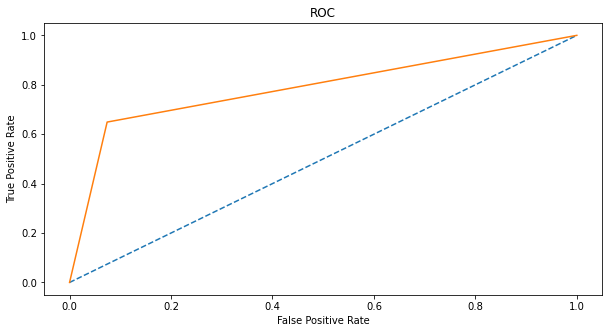

In [85]:
dt_test_auc,dt_test_fpr,dt_test_tpr = Decision_tree_ROC()

In [86]:
dt_test_precision,dt_test_recall,dt_test_f1 = Decision_tree_matrices_score()

dt_test_precision  0.665
dt_test_recall  0.649
dt_test_f1  0.657


<font size="3"><div class="alert alert-block alert-success">
Using Grid search for tuning Decision tree model performance
</div></font>

In [87]:
param_grid = {
    'max_depth':[6,7,8],
    'min_samples_leaf': [4,5,6],
    'min_samples_split': [12,15,18]
}

dt_model = DecisionTreeClassifier(random_state=0)

grid_search = GridSearchCV(estimator = dt_model, param_grid = param_grid, cv = 10)

grid_search.fit(X_train, y_train)

grid_search.best_params_

{'max_depth': 8, 'min_samples_leaf': 6, 'min_samples_split': 15}

In [88]:
best_grid = grid_search.best_estimator_


In [89]:
ytest_predict_dt_tuned = best_grid.predict(X_test)

In [90]:
DecisionT_GS_confusion_matrix()

[[877  41]
 [ 93 115]]


<font size="3"><div class="alert alert-block alert-success">
Tuned decision tree classification report 
</font></div>

In [91]:
DecisionT_GS_clsf_report()

              precision    recall  f1-score   support

           0       0.90      0.96      0.93       918
           1       0.74      0.55      0.63       208

    accuracy                           0.88      1126
   macro avg       0.82      0.75      0.78      1126
weighted avg       0.87      0.88      0.87      1126



<font size="3"><div class="alert alert-block alert-success">
It can be observed that accuracy has been increased by 1% and has better precision score that means now model can predict more churned customers correctly than previous model
</font></div>

<font size="3"><div class="alert alert-block alert-success">
Tuned Decision tree model ROC curve
</font></div>

AUC: 0.87


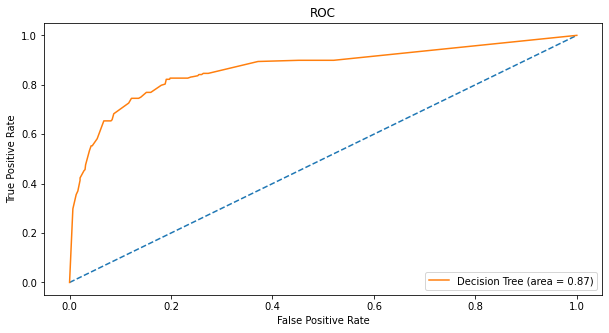

In [92]:
dt_test_auc,dt_test_fpr, dt_test_tpr = Decision_tree_GS_ROC()

<font size="3"><div class="alert alert-block alert-success">
It can be observed that the AUC value of tuned decision tree model is much better than previous model
</font></div>

# Random Forest

<font size="3"><div class="alert alert-block alert-success">
 
- The random forest model was overfitting as the values for all the metrics are 100% for train set 
  but comparatively very low values for test set. Similar to Decision tree hyperparameter tuning of the model is 
  performed for better model performance.
- Feature selection is done based of feature importance value and high importance features are used to build the model.


### Outcome:


- Accuracy :               91%
- AUC (Area under curve) : 0.95
- Precision :              91%
- Recall  :               60%
- F1 score :               72%

    
#### From above results we can see that Recall rate is of 60% indicating that more than half of the churned customers could be predicted correctly by this model. 
#### The precision is 91% which implies that the model has done a very good job in not predicting too many false positives.
#### The AUC score is very good for this model as compared to previous two models.
    
</div></font>

rfcl=RandomForestClassifier(random_state=0)

In [93]:
rfcl=RandomForestClassifier(random_state=0)
rfcl=rfcl.fit(X_train,y_train)
print (pd.DataFrame(rfcl.feature_importances_, columns = ["Imp"], index = X_train.columns).sort_values(by='Imp',ascending=False))

                                          Imp
Tenure                               0.235451
CashbackAmount                       0.084822
WarehouseToHome                      0.082325
SatisfactionScore                    0.063920
OrderAmountHikeFromlastYear          0.060060
NumberOfAddress                      0.052078
DaySinceLastOrder                    0.050631
NumberOfDeviceRegistered             0.048878
OrderCount                           0.037731
CouponUsed                           0.034607
HourSpendOnApp                       0.030956
PreferedOrderCat_Mobile Phone        0.029569
CityTier                             0.022461
MaritalStatus_Married                0.021533
Complain                             0.020776
PreferredLoginDevice_Mobile Phone    0.018807
Gender_Male                          0.017027
PreferredPaymentMode_Credit Card     0.016934
PreferredPaymentMode_Debit Card      0.014826
PreferedOrderCat_Laptop & Accessory  0.014687
MaritalStatus_Single              

In [94]:
importances=rfcl.feature_importances_
indices = np.argsort(importances)[::-1]
names = [data.columns[i] for i in indices]

<font size="3"><div class="alert alert-block alert-success">
Plotting important features  
</font></div>

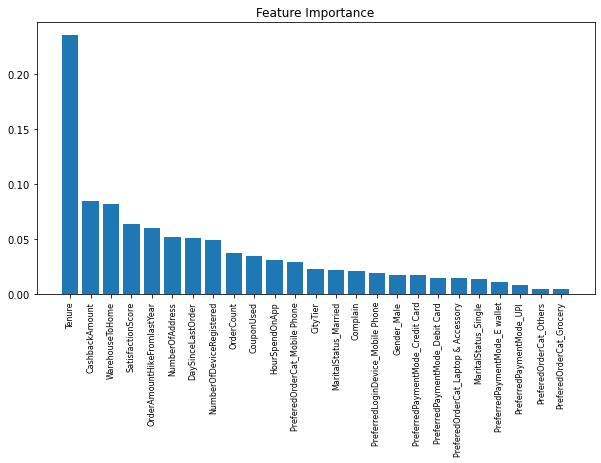

In [95]:
# Barplot: Add bars
plt.bar(range(X.shape[1]), importances[indices])
# Add feature names as x-axis labels
plt.xticks(range(X.shape[1]), names, rotation=90, fontsize = 8)
# Create plot title
plt.title("Feature Importance")
# Show plot
plt.show()

In [96]:
ytest_predict_rf = rfcl.predict(X_test)
ytest_predict_rf

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

In [97]:
def RandomForest_confusion_matrix():
    sns.heatmap((confusion_matrix(y_test,ytest_predict_rf)),annot=True,fmt='.5g'
                ,cmap='Blues');
    plt.xlabel('Predicted');
    plt.ylabel('Actuals',rotation=0);

In [98]:
def RandomForest_test_score():
    rf_test_score=metrics.accuracy_score(y_test,ytest_predict_rf)
    return rf_test_score

In [99]:
def RandomForest_clf_report():
    print(metrics.classification_report(y_test,ytest_predict_rf,digits=2))

In [100]:
def RandomForest_ROC():
    # predict probabilities
    probs = rfcl.predict_proba(X_test)
    # keep probabilities for the positive outcome only
    probs = probs[:, 1]
    # calculate AUC
    rf_test_auc = roc_auc_score(y_test, probs)
    print('AUC: %.3f' % rf_test_auc)
    # calculate roc curve
    rf_test_fpr, rf_test_tpr, train_thresholds = roc_curve(y_test, probs)
    plt.plot([0, 1], [0, 1], linestyle='--')
    # plot the roc curve for the model
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.plot(rf_test_fpr, rf_test_tpr)
    return rf_test_auc,rf_test_fpr, rf_test_tpr

In [101]:
def RandomForest_metrics_score():
    rf_metrics=classification_report(y_test,ytest_predict_rf,output_dict=True)
    df=pd.DataFrame(rf_metrics).transpose()
    rf_test_precision=round(df.loc["1"][0],3)
    rf_test_recall=round(df.loc["1"][1],3)
    rf_test_f1=round(df.loc["1"][2],3)
    print ('rf_test_precision ',rf_test_precision)
    print ('rf_test_recall ',rf_test_recall)
    print ('rf_test_f1 ',rf_test_f1)
    return rf_test_precision,rf_test_recall,rf_test_f1

### Tuning Random Forest

In [102]:

rfcl_tuned=RandomForestClassifier(n_estimators=500,max_depth=10,max_features=8,min_samples_split=60,n_jobs=1,random_state=0)
rfcl_tuned.fit(X_train,y_train)
#ytrain_predict_rf_tuned=rfcl_tuned.predict(X_train)
ytest_predict_rf_tuned=rfcl_tuned.predict(X_test)

In [103]:
def tuned_RandomForest_confusion_matrix():
    print(confusion_matrix(y_test,ytest_predict_rf_tuned))

In [104]:
def tuned_RandomForest_clf_report():
    print(classification_report(y_test,ytest_predict_rf_tuned))

In [105]:
def tuned_RandomForest_ROC():
    # predict probabilities
    probs = rfcl_tuned.predict_proba(X_test)
    # keep probabilities for the positive outcome only
    probs = probs[:, 1]
    # calculate AUC
    rf_test_auc = roc_auc_score(y_test, probs)
    print('AUC: %.2f' % rf_test_auc)
    # calculate roc curve
    rf_test_fpr, rf_test_tpr, train_thresholds = roc_curve(y_test, probs)
    plt.plot([0, 1], [0, 1], linestyle='--')
    # plot the roc curve for the model
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.plot(rf_test_fpr, rf_test_tpr,label='Random Forest (area = '+str(rf_test_auc.round(2))+')')
    plt.legend(loc=4)
    plt.show()
    return rf_test_auc,rf_test_fpr,rf_test_tpr

<font size="3"><div class="alert alert-block alert-success">
Confusion matrix for random forest model
</font></div>

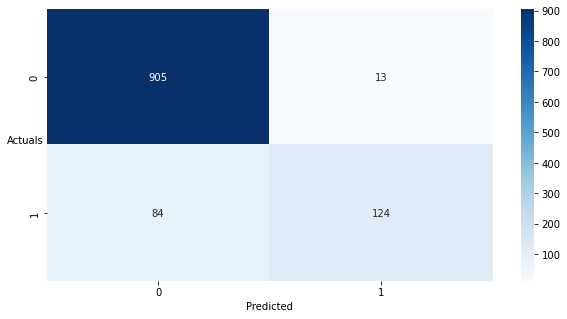

In [106]:
RandomForest_confusion_matrix()

In [107]:
rf_test_score=RandomForest_test_score()

<font size="3"><div class="alert alert-block alert-success">
Classification report for random forest model
</font></div>

In [108]:
RandomForest_clf_report()

              precision    recall  f1-score   support

           0       0.92      0.99      0.95       918
           1       0.91      0.60      0.72       208

    accuracy                           0.91      1126
   macro avg       0.91      0.79      0.83      1126
weighted avg       0.91      0.91      0.91      1126



<font size="3"><div class="alert alert-block alert-success">
Printing Receiver Operating Characteristic Curve (ROC) of random morest model
</font></div>

AUC: 0.952


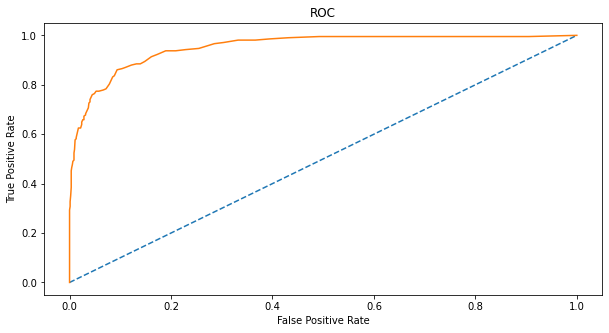

In [109]:
rf_test_auc,rf_test_fpr,rf_test_tpr = RandomForest_ROC()

<font size="3"><div class="alert alert-block alert-success">
Tuned metrics performance values of random forest model
</font></div>

In [110]:
rf_test_precision,rf_test_recall,rf_test_f1 = RandomForest_metrics_score()

rf_test_precision  0.905
rf_test_recall  0.596
rf_test_f1  0.719


<font size="3"><div class="alert alert-block alert-success">
Confusion matrix for tuned random forest model
</font></div>

In [111]:
tuned_RandomForest_confusion_matrix()

[[894  24]
 [104 104]]


<font size="3"><div class="alert alert-block alert-success">
Classification report of tuned random forest model
</font></div>

In [112]:
tuned_RandomForest_clf_report()

              precision    recall  f1-score   support

           0       0.90      0.97      0.93       918
           1       0.81      0.50      0.62       208

    accuracy                           0.89      1126
   macro avg       0.85      0.74      0.78      1126
weighted avg       0.88      0.89      0.88      1126



<font size="3"><div class="alert alert-block alert-success">
Printing Receiver Operating Characteristic Curve (ROC) for tuned random forest model
</font></div>

AUC: 0.92


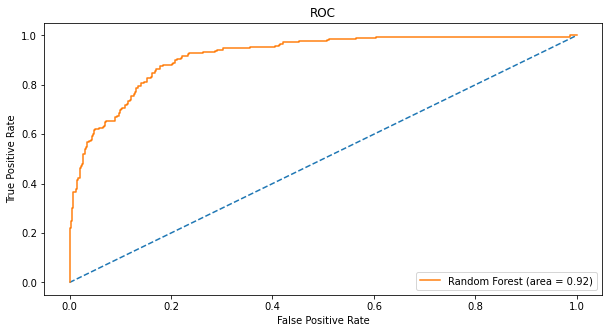

In [113]:
rf_test_auc,rf_test_fpr,rf_test_tpr = tuned_RandomForest_ROC()

### Extreme Gradient Boosting (XGB)

<font size="3"><div class="alert alert-block alert-success">

XGBoost model was found out to have very good accuracy, precision and recall results as compared to other models.

#### Outcome:
- Accuracy : 92%
- Precision : 87%
- Recall : 68%
- F1 score : 77%
    
#### From above results we can observe that XGB model has correctly predicted 87% as a churned people and also have a good accuracy score of 92%

</div></font>

In [114]:
xgb=XGBClassifier()

xgb.fit(X_train,y_train)
ytest_predict_xgb = xgb.predict(X_test)
ytest_predict_xgb

array([0, 0, 0, ..., 0, 0, 0])

In [115]:
def XGB_confusion_matrix():
    sns.heatmap((confusion_matrix(y_test,ytest_predict_xgb)),annot=True,fmt='.5g'
                ,cmap='Blues');
    plt.xlabel('Predicted');
    plt.ylabel('Actuals',rotation=0);

In [116]:
def XGB_test_score():
    xgb_test_score=accuracy_score(y_test,ytest_predict_xgb)
    return xgb_test_score

In [117]:
def XGB_clf_report():
    report=classification_report(y_test,ytest_predict_xgb,digits=3,output_dict=True)
    df = pd.DataFrame(report).transpose()
    round(df,3)
    print(classification_report(y_test,ytest_predict_xgb,digits=3))

In [118]:
def plot_XGB_ROC():
    # predict probabilities
    probs = xgb.predict_proba(X_test)
    # keep probabilities for the positive outcome only
    probs = probs[:, 1]
    # calculate AUC
    xgb_test_auc = roc_auc_score(y_test, probs)
    print('AUC: %.3f' % xgb_test_auc)
    # calculate roc curve
    xgb_test_fpr, xgb_test_tpr, train_thresholds = roc_curve(y_test, probs)
    plt.plot([0, 1], [0, 1], linestyle='--')
    # plot the roc curve for the model
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.plot(xgb_test_fpr, xgb_test_tpr)
    return xgb_test_auc,xgb_test_fpr,xgb_test_tpr

In [119]:
def print_XGB_metrics():
    xgb_metrics=classification_report(y_test,ytest_predict_xgb,output_dict=True)
    df=pd.DataFrame(xgb_metrics).transpose()
    xgb_test_precision=round(df.loc["1"][0],3)
    xgb_test_recall=round(df.loc["1"][1],3)
    xgb_test_f1=round(df.loc["1"][2],3)
    print ('xgb_test_precision ',xgb_test_precision)
    print ('xgb_test_recall ',xgb_test_recall)
    print ('xgb_test_f1 ',xgb_test_f1)
    return xgb_test_precision,xgb_test_recall,xgb_test_f1

<font size="3"><div class="alert alert-block alert-success">
Confusion matrix for XGB model
</font></div>

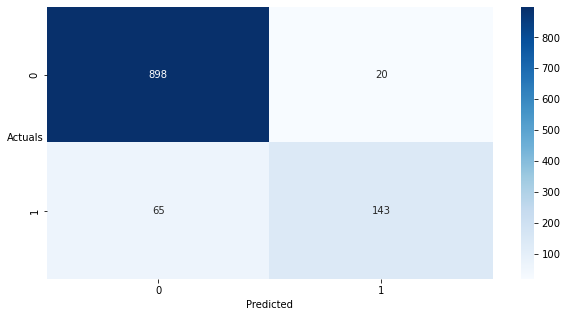

In [120]:
XGB_confusion_matrix()

In [121]:
xgb_test_score=XGB_test_score()

<font size="3"><div class="alert alert-block alert-success">
Classification report of XGB model
</font></div>

In [122]:
XGB_clf_report()

              precision    recall  f1-score   support

           0      0.933     0.978     0.955       918
           1      0.877     0.688     0.771       208

    accuracy                          0.925      1126
   macro avg      0.905     0.833     0.863      1126
weighted avg      0.922     0.925     0.921      1126



<font size="3"><div class="alert alert-block alert-success">
Printing Receiver Operating Characteristic Curve (ROC) for XGB model
</font></div>

AUC: 0.957


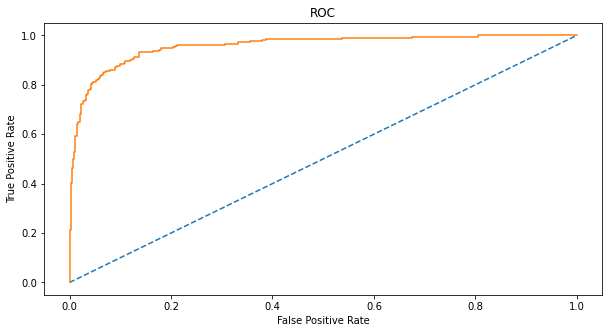

In [123]:
xgb_test_auc,xgb_test_fpr,xgb_test_tpr=plot_XGB_ROC()

<font size="3"><div class="alert alert-block alert-success">
Printing precision recall and f1 score of XGB model
</font></div>

In [124]:
xgb_test_precision,xgb_test_recall,xgb_test_f1 = print_XGB_metrics()

xgb_test_precision  0.877
xgb_test_recall  0.688
xgb_test_f1  0.771


## Comparison of Performance Metrics

<font size="3"><div class="alert alert-block alert-success">

From below given table clearly, XGBoost model is the optimum model as it has good balance between precision and recall 
and it is also stable model.

The precision is 0.88 and the recall is 0.69 which indicates that the model has correctly predicted 69% 
of the churned customers. 

The AUC score of 0.96 of XGBoost model is also good when compared to other models.
    
Hence, XGBoost model can be used to predict whether a customer will churn or not based on previous data for an E-commerce company.

</div></font>

In [125]:
def compare_models_metrics():
    index=['Accuracy', 'AUC', 'Recall','Precision','F1 Score']
    data = pd.DataFrame({'Logistic Test':[logistic_test_score,logistic_test_auc,logistic_test_recall,logistic_test_precision,logistic_test_f1],
            'Decision Tree Test':[dt_test_score,dt_test_auc,dt_test_recall,dt_test_precision,dt_test_f1],
            'Random Forest Test':[rf_test_score,rf_test_auc,rf_test_recall,rf_test_precision,rf_test_f1],
            'XGB Test':[xgb_test_score,xgb_test_auc,xgb_test_recall,xgb_test_precision,xgb_test_f1],
            },index=index)
    return round(data,2)

In [126]:
def compare_ROC_Ofmodels():
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.plot(logistic_test_fpr, logistic_test_tpr,color='red',label="Logistic")
    plt.plot(dt_test_fpr, dt_test_tpr,color='orange',label="Decision Tree")
    plt.plot(rf_test_fpr,rf_test_tpr,color='blue',label="Random Forest")
    plt.plot(xgb_test_fpr,xgb_test_tpr,color='brown',label="XGB")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower right')

<font size="3"><div class="alert alert-block alert-success">
Comparing performance metrics of different predictive model
</font></div>

In [127]:
data=compare_models_metrics()
data

,Logistic Test,Decision Tree Test,Random Forest Test,XGB Test
Accuracy,0.86,0.87,0.91,0.92
AUC,0.86,0.87,0.92,0.96
Recall,0.53,0.65,0.60,0.69
Precision,0.65,0.66,0.90,0.88
F1 Score,0.59,0.66,0.72,0.77


<font size="3"><div class="alert alert-block alert-success">
It can be observed from above table that Random forest model is the most optimal model with balanced performance metrics scores
</font></div>

<font size="3"><div class="alert alert-block alert-success">
Comparing models based on ROC curve
</font></div>

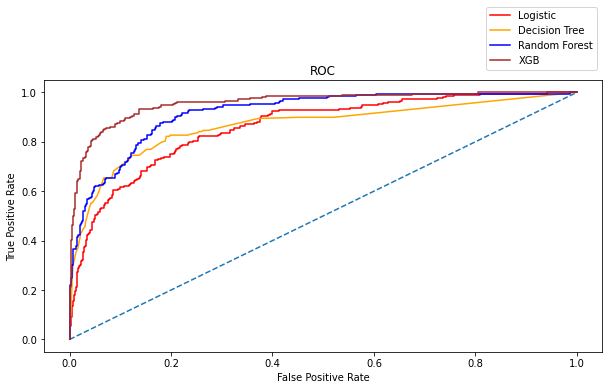

In [128]:
compare_ROC_Ofmodels()

<font size="3"><div class="alert alert-block alert-success">
It can be observed that XGB has the highest AUC value followed by random forest, decision tree and logistic regression model
</font></div>